In [121]:
%load_ext autoreload
%autoreload 2
import os
from Utils.Utils import extract_analogIO, check_single_rec_file, extract_DIO, check_timestamp_gaps, get_mouse_name,get_recording_day, find_mat_files_with_same_day, check_gpu_availability
from pathlib import Path
import numpy as np
from spikeinterface.extractors import read_spikegadgets
import spikeinterface.full as si
from spikeinterface.preprocessing import detect_bad_channels
from Utils.Settings import channel_label_color_dict
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import panel as pn

pn.extension(design="bootstrap", sizing_mode="fixed",throttled=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Ott lab spikesorting single session
#####  Multi-Neuropixels recording using SpikeGadgets

## Select file

In [183]:
# folder containing .rec file
path_recording_folder = Path("/alzheimer/Roberto/Dariya/12/ephys/20231210_191835.rec/")


In [184]:
mouse_n = get_mouse_name(path_recording_folder)
day = get_recording_day(path_recording_folder)

In [185]:
day

'20231210'

In [186]:
path_recording, rec_file_name = check_single_rec_file(path_recording_folder)

Exactly one .rec file found: 20231210_191835.rec


In [187]:
raw_rec = read_spikegadgets(path_recording)

In [118]:
f"Probes present: {raw_rec.get_probes()}"

'Probes present: [Probe - 384ch - 1shanks, Probe - 384ch - 1shanks]'

In [125]:
analog_dict = readTrodesExtractedDataFile(Path("/alzheimer/Roberto/Dariya/12/ephys/20231210_191835.rec/20231210_191835.analog/20231210_191835.timestamps.dat"))

/alzheimer/Roberto/Github/spikesorting/Utils/TrodesToPython/readTrodesExtractedDataFile3.py:114: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


In [128]:
analog_dict["data"].shape

(31760248,)

In [120]:
raw_rec.get_total_samples()

31760248

In [309]:
%%time
noise_levels = si.get_noise_levels(raw_rec, return_scaled=True)

Text(0.5, 0, 'noise  [microV]')

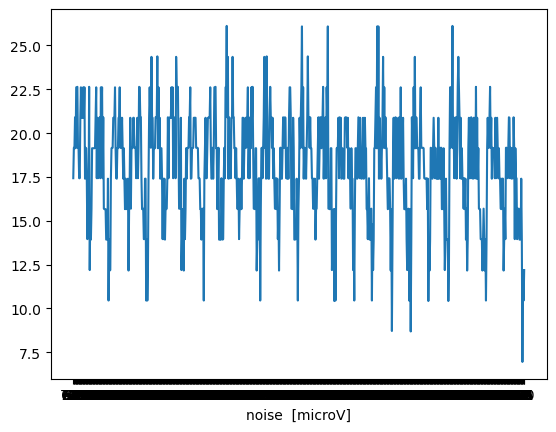

In [327]:
fig, ax = plt.subplots()
_ = ax.plot(raw_rec.channel_ids, noise_levels)
ax.set_xlabel('noise  [microV]')

### Inspect probes

In [190]:
rec_filt = si.highpass_filter(raw_rec, freq_min=300.)

In [191]:
# detect noisy, dead, and out-of-brain channels
bad_channel_ids, channel_labels = detect_bad_channels(high_passed_rec, dead_channel_threshold=-.5)

/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/site-packages/spikeinterface/preprocessing/detect_bad_channels.py:333: RuntimeWarning: invalid value encountered in divide
  xcorr = np.sum(raw * ref[:, np.newaxis], axis=0) / np.sum(ref**2)


In [192]:
channels_df = pd.DataFrame([rec_filt.channel_ids, channel_labels], index=["channel_id", "channel_label"]).T

In [275]:
channels_colors = [channel_label_color_dict[label] for label in channel_labels]

In [259]:
y_lim_widget = pn.widgets.EditableRangeSlider(
    name='y_lim', start=0, end=raw_rec.get_channel_locations().max(), value=(raw_rec.get_channel_locations().max()-800, raw_rec.get_channel_locations().max()-200),
    step=10)

@pn.depends(y_lim_widget)
def inspect_probes_channels_labels(ylim):
    fig, axs = plt.subplots(1,3, figsize=(10, 6))
    for label in channels_df["channel_label"].unique():
        si.plot_probe_map(raw_rec, channel_ids= channels_df[channels_df["channel_label"]==label]["channel_id"].values.astype(str), ax=axs[0], with_channel_ids=False, contacts_colors=channel_label_color_dict[label])
    
    for label in channels_df["channel_label"].unique():
        si.plot_probe_map(raw_rec, channel_ids= channels_df[channels_df["channel_label"]==label]["channel_id"].values.astype(str), ax=axs[1], with_channel_ids=False, contacts_colors=channel_label_color_dict[label])
    
    
    patches = [mpatches.Patch(color=color, label=label) for label, color in channel_label_color_dict.items()]
    
    axs[2].legend(handles=patches, loc='upper left', frameon=False );
    axs[2].axis("off");
    #axs[0].
    
    axs[1].set_ylim(ylim[0], ylim[1] )
    
    # Draw a rectangle on axs[0] with these ylims
    # Assuming arbitrary x values, here 0 to 10 for illustration
    rect = mpatches.Rectangle((-100, ylim[0]), 600, ylim[1] - ylim[0], linewidth=1, edgecolor='r', facecolor='none')
    
    axs[0].add_patch(rect)
    plt.close()
    return pn.pane.Matplotlib(fig)

Column(design=<class 'panel.theme.bootst...)
    [0] EditableRangeSlider(design=<class 'panel.theme.bootst..., end=3920.0, name='y_lim', step=10, value=(3120.0, 3720.0), width=300)
    [1] ParamFunction(function, _pane=Matplotlib, defer_load=False, design=<class 'panel.theme.bootst...)
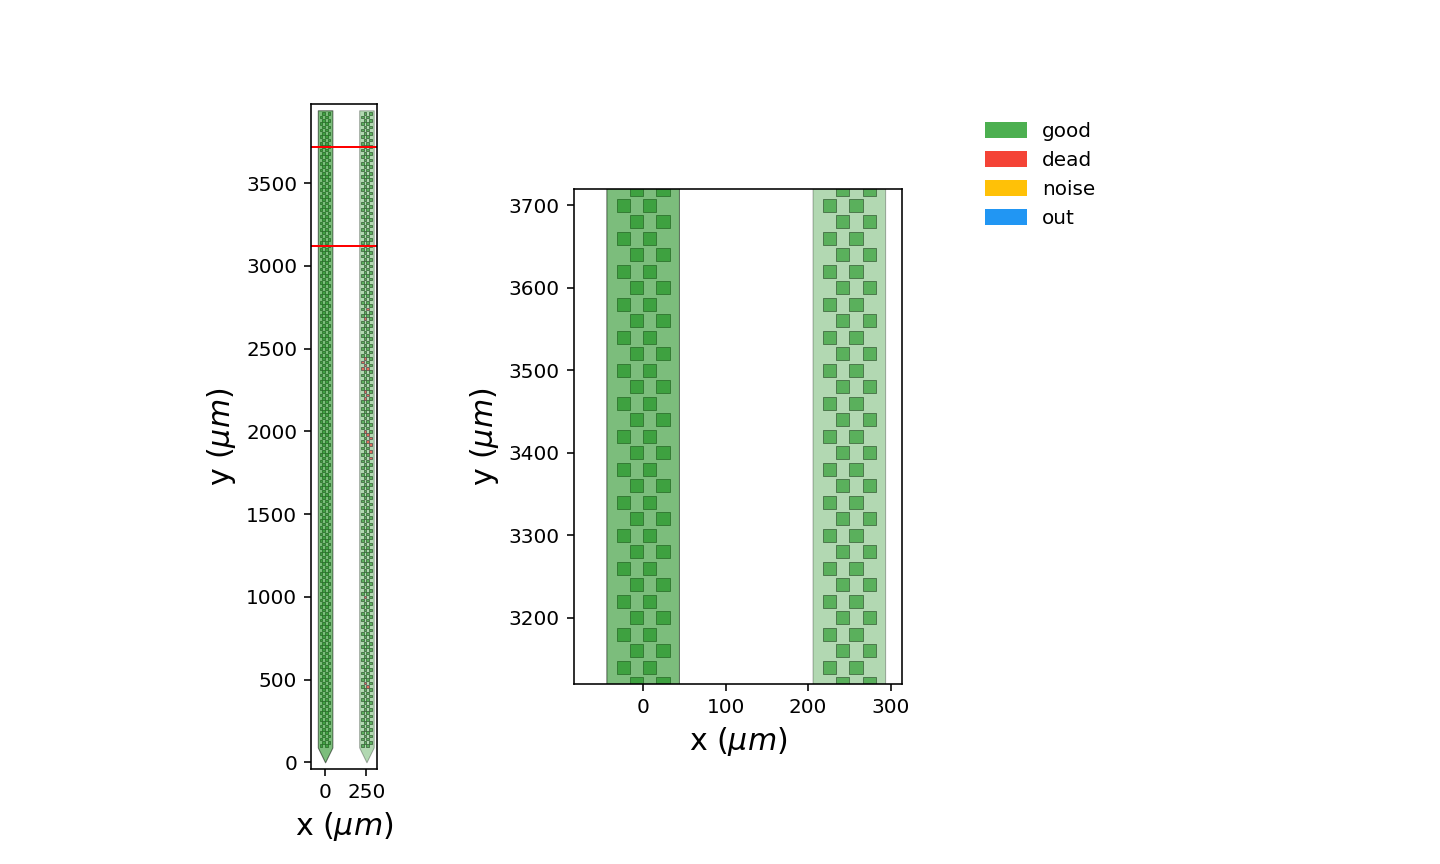

In [260]:
pn.Column(y_lim_widget, inspect_probes_channels_labels)

In [286]:
y_lim_widget = pn.widgets.EditableRangeSlider(
    name='y_lim', start=0, end=raw_rec.get_channel_locations().max(), value=(raw_rec.get_channel_locations().max()-800, raw_rec.get_channel_locations().max()-200),
    step=10)

@pn.depends(y_lim_widget)
def inspect_probes_channels_labels(ylim):
    fig, axs = plt.subplots(1,3, figsize=(10, 6))

    si.plot_probe_map(raw_rec, color_channels=channels_colors, ax=axs[0], with_channel_ids=False)
      
    si.plot_probe_map(raw_rec, color_channels=channels_colors, ax=axs[1], with_channel_ids=False)
    
    
    patches = [mpatches.Patch(color=color, label=label) for label, color in channel_label_color_dict.items()]
    
    axs[2].legend(handles=patches, loc='upper left', frameon=False );
    axs[2].axis("off");
    #axs[0].
    
    axs[1].set_ylim(ylim[0], ylim[1] )
    
    # Draw a rectangle on axs[0] with these ylims
    # Assuming arbitrary x values, here 0 to 10 for illustration
    rect = mpatches.Rectangle((-100, ylim[0]), 600, ylim[1] - ylim[0], linewidth=1, edgecolor='r', facecolor='none')
    
    axs[0].add_patch(rect)
    plt.close()
    return pn.pane.Matplotlib(fig)

Column(design=<class 'panel.theme.bootst...)
    [0] EditableRangeSlider(design=<class 'panel.theme.bootst..., end=3920.0, name='y_lim', step=10, value=(3120.0, 3720.0), width=300)
    [1] ParamFunction(function, _pane=Matplotlib, defer_load=False, design=<class 'panel.theme.bootst...)
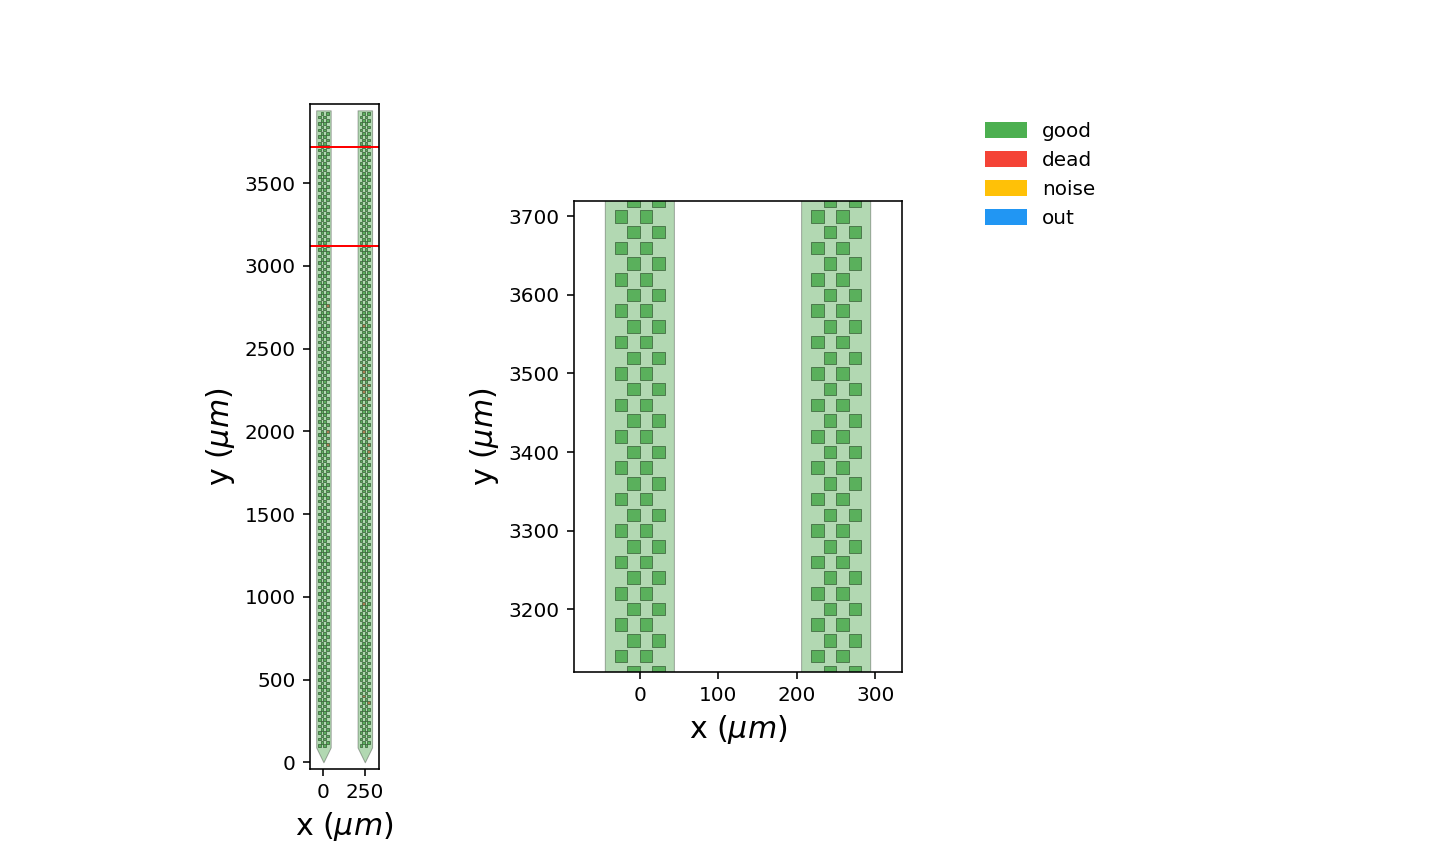

In [287]:
pn.Column(y_lim_widget, inspect_probes_channels_labels)

In [202]:
count = np.unique(channel_labels, return_counts=True)
if (count[0].shape[0] == 1) & (count[0][0]=="good"):
     print("no bad channels")
else:
    for n in range(count[0].shape[0]):
        print(f"{count[1][n]} {count[0][n]} channels")
    rec_filt = rec_filt.remove_channels(bad_channel_ids)
    print("bad channels removed")

20 dead channels
748 good channels
bad channels removed


In [100]:
%%time

# perform the phase shift (similar to IBL destriping or `tshift` option in CatGT):
# rec_shifted = si.phase_shift(rec_filt) # 'inter_sample_shift' is not a property!

# subtract the median across all channels
#rec = si.common_reference(rec_filt, 
#                          operator="median", 
#                          reference="global")


CPU times: user 29 µs, sys: 6 µs, total: 35 µs
Wall time: 76.1 µs


In [101]:
#si.get_default_sorter_params(sorter_name_or_class='kilosort4')

In [102]:
%%time

check_gpu_availability()

split_preprocessed_recording = raw_rec.split_by("group")
for group, sub_rec in split_preprocessed_recording.items():
    sorting = si.run_sorter(
        sorter_name="kilosort4",
        recording=sub_rec,
        output_folder=f"{path_recording_folder}/spike_interface_output/probe{group}",
        verbose=True,
        remove_existing_folder=True
        )

GPU available: n = 1
Loading recording with SpikeInterface...
number of samples: 31760248
number of channels: 384
numbef of segments: 1
sampling rate: 30000.0
dtype: int16
Preprocessing filters computed in  7.38s; total  7.38s

computing drift
Re-computing universal templates from data.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [08:36<00:00,  1.03it/s]


drift computed in  527.25s; total  534.63s

Extracting spikes using templates
Re-computing universal templates from data.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [08:34<00:00,  1.03it/s]


2660633 spikes extracted in  523.71s; total  1058.35s

First clustering


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [08:53<00:00,  5.56s/it]


315 clusters found, in  534.55s; total  1592.90s

Extracting spikes using cluster waveforms


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [04:26<00:00,  1.99it/s]


3295389 spikes extracted in  267.40s; total  1860.30s

Final clustering


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [07:54<00:00,  4.94s/it]


277 clusters found, in  474.07s; total  2334.36s

Merging clusters
274 units found, in  2.39s; total  2336.76s

Saving to phy and computing refractory periods
50 units found with good refractory periods

Total runtime: 2368.57s = 00:39:29 h:m:s
kilosort4 run time 2373.54s
Loading recording with SpikeInterface...
number of samples: 31760248
number of channels: 384
numbef of segments: 1
sampling rate: 30000.0
dtype: int16
Preprocessing filters computed in  7.40s; total  7.40s

computing drift
Re-computing universal templates from data.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [08:33<00:00,  1.03it/s]


drift computed in  525.22s; total  532.61s

Extracting spikes using templates
Re-computing universal templates from data.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [08:31<00:00,  1.04it/s]


2663568 spikes extracted in  520.47s; total  1053.08s

First clustering


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [09:10<00:00,  5.73s/it]


280 clusters found, in  550.92s; total  1604.01s

Extracting spikes using cluster waveforms


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [04:16<00:00,  2.07it/s]


2707623 spikes extracted in  256.53s; total  1860.53s

Final clustering


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [05:32<00:00,  3.46s/it]


269 clusters found, in  332.19s; total  2192.72s

Merging clusters
265 units found, in  1.66s; total  2194.38s

Saving to phy and computing refractory periods
41 units found with good refractory periods

Total runtime: 2223.44s = 00:37:3 h:m:s
kilosort4 run time 2226.19s
CPU times: user 17h 14min 18s, sys: 30min 51s, total: 17h 45min 10s
Wall time: 1h 16min 45s


In [270]:
group

0

In [271]:
sorting = si.read_sorter_folder(f"{path_recording_folder}/spike_interface_output/probe{group}")

In [272]:
sorting

KiloSortSortingExtractor: 274 units - 1 segments - 30.0kHz

In [273]:
analyzer = si.create_sorting_analyzer(sorting, recording, sparse=True, format="memory")

estimate_sparsity:   0%|          | 0/1059 [00:00<?, ?it/s]

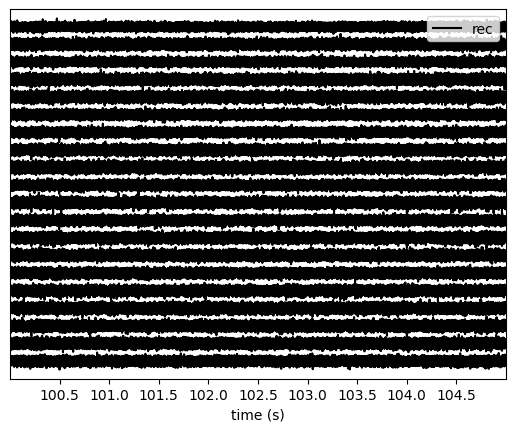

In [468]:
import spikeinterface.widgets as sw

sw.plot_traces(raw_rec.channel_slice(channel_ids=bad_channel_ids), time_range=(100, 105), return_scaled=True)

In [203]:
gaps = check_timestamp_gaps(raw_dat)

No gaps detected.


## load bpod mat file behavior

In [46]:
bpod_file = find_mat_files_with_same_day(path_recording_folder.parent.parent / "bpod_session" , day)

.mat file found: /alzheimer/Roberto/Dariya/12/bpod_session/20231210_193822/12_DetectionConfidence_20231210_193822.mat
.mat file found: /alzheimer/Roberto/Dariya/12/bpod_session/20231210_183107/12_DetectionConfidence_20231210_183107.mat


In [47]:
bpod_file

[PosixPath('/alzheimer/Roberto/Dariya/12/bpod_session/20231210_193822/12_DetectionConfidence_20231210_193822.mat'),
 PosixPath('/alzheimer/Roberto/Dariya/12/bpod_session/20231210_183107/12_DetectionConfidence_20231210_183107.mat')]

In [48]:
from scipy.io.matlab import loadmat

bpod_data = loadmat(bpod_file[1], simplify_cells=True)['SessionData']

In [49]:

bpod_data['nTrials']
bpod_data['TrialStartTimestamp']


array([  7.4648,  19.4012,  31.2975,  43.1718,  55.0648,  66.9347,
        78.796 ,  90.2763,  98.9617, 106.0713, 115.1048, 126.9976,
       138.8658, 144.507 , 155.3506, 159.7117, 168.3048, 175.6697,
       181.2034, 188.7903, 194.0013, 205.9308, 217.813 , 229.6981,
       241.5831, 253.4919, 265.4246, 277.3641, 289.2501, 301.1387,
       313.0633, 320.819 , 335.2972, 339.4911, 345.4069, 357.305 ,
       369.2064, 381.0973, 392.9834, 404.8708, 416.7872, 431.238 ,
       437.2389, 445.8118, 452.7717, 460.7699, 472.5234, 484.4424,
       496.3307, 508.2372, 520.1434, 532.0459, 540.9542, 552.8516,
       564.7907, 576.6742, 588.5756, 600.4713, 612.4109, 625.202 ,
       634.6964, 643.1432, 655.1892, 678.8826, 686.2499, 695.7341,
       703.6226, 709.2556, 719.8747, 725.4639, 737.7237, 746.5178,
       750.7419, 758.6829, 765.3605, 775.1839, 782.9444, 791.1255,
       800.5327, 807.6973, 818.9813, 824.3295, 836.2526, 848.1689,
       856.4333, 864.4537, 871.0406, 884.1339, 889.8463, 898.0

## Export Analog IO channels

In [ ]:
%%time
extract_analogIO(path_recording_folder, path_recording)

## Export Digital IO channels

In [9]:
#check if already available, if not extract
extract_DIO(path_recording_folder, path_recording)

'.DIO' folder alread available: 20231210_191835.DIO


In [10]:
path_DIO_folder = Path(path_recording_folder,  f"{rec_file_name[:rec_file_name.rfind('.')]}.DIO")

In [123]:
from Utils.TrodesToPython.readTrodesExtractedDataFile3 import readTrodesExtractedDataFile

In [39]:
DIO_port = 1

In [40]:
DIO_dict = readTrodesExtractedDataFile(Path(path_DIO_folder, f"{rec_file_name[:rec_file_name.rfind('.')]}.dio_Controller_Din{DIO_port}.dat"))

In [43]:
# Each data point is (timestamp, state) -> break into separate arrays
DIO_data = DIO_dict['data']
DIO_states = np.array([tup[1] for tup in DIO_data])
DIO_timestamps = np.array([tup[0] for tup in DIO_data])/float(DIO_dict['clockrate'])
assert DIO_states.shape == DIO_timestamps.shape

In [44]:
raw_rec.get_total_samples(), DIO_timestamps.shape

(31760248, (199,))

In [52]:
DIO_timestamps[DIO_states.astype(bool)]-DIO_timestamps[DIO_states.astype(bool)][0]

array([  53.60816667,   65.54466667,   77.4411    ,   89.31553333,
        101.20866667,  113.07866667,  124.9401    ,  136.4205    ,
        145.106     ,  152.21566667,  161.24926667,  173.1422    ,
        185.0105    ,  190.65176667,  201.49546667,  205.85663333,
        214.4498    ,  221.8148    ,  227.34853333,  234.93553333,
        240.14656667,  252.0762    ,  263.9585    ,  275.84373333,
        287.72886667,  299.63776667,  311.5706    ,  323.51023333,
        335.39633333,  347.28506667,  359.20976667,  366.96556667,
        381.4439    ,  385.63783333,  391.5537    ,  403.45193333,
        415.35343333,  427.24446667,  439.13066667,  451.0182    ,
        462.93473333,  477.38566667,  483.38663333,  491.9596    ,
        498.91956667,  506.91786667,  518.67146667,  530.5906    ,
        542.479     ,  554.38563333,  566.29193333,  578.19456667,
        587.10296667,  599.00046667,  610.9397    ,  622.8233    ,
        634.72483333,  646.62063333,  658.56036667,  671.3516 

In [53]:
bpod_data['TrialStartTimestamp'] - bpod_data['TrialStartTimestamp'][0]

array([  7.4648,  19.4012,  31.2975,  43.1718,  55.0648,  66.9347,
        78.796 ,  90.2763,  98.9617, 106.0713, 115.1048, 126.9976,
       138.8658, 144.507 , 155.3506, 159.7117, 168.3048, 175.6697,
       181.2034, 188.7903, 194.0013, 205.9308, 217.813 , 229.6981,
       241.5831, 253.4919, 265.4246, 277.3641, 289.2501, 301.1387,
       313.0633, 320.819 , 335.2972, 339.4911, 345.4069, 357.305 ,
       369.2064, 381.0973, 392.9834, 404.8708, 416.7872, 431.238 ,
       437.2389, 445.8118, 452.7717, 460.7699, 472.5234, 484.4424,
       496.3307, 508.2372, 520.1434, 532.0459, 540.9542, 552.8516,
       564.7907, 576.6742, 588.5756, 600.4713, 612.4109, 625.202 ,
       634.6964, 643.1432, 655.1892, 678.8826, 686.2499, 695.7341,
       703.6226, 709.2556, 719.8747, 725.4639, 737.7237, 746.5178,
       750.7419, 758.6829, 765.3605, 775.1839, 782.9444, 791.1255,
       800.5327, 807.6973, 818.9813, 824.3295, 836.2526, 848.1689,
       856.4333, 864.4537, 871.0406, 884.1339, 889.8463, 898.0

In [5]:

plt.plot(np.abs(np.diff(DIO_timestamps[DIO_states.astype(bool)])[:-1] - np.diff(bpod_data['TrialStartTimestamp'])))

NameError: name 'np' is not defined

In [ ]:
len(recorded_start_ts), len(session_data['TrialStartTimestamp'])